In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit, expit
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from collections import namedtuple, defaultdict
from itertools import product
from joblib import Memory, load, dump
#from boruta_wrapper import BorutaWrapper
from sklearn.metrics import mean_squared_error, r2_score
import re
import sys
import traceback
import pickle

In [30]:
memory = Memory('./cache', verbose=0)

In [31]:
RANDOM_STATE_SEED = 57
READ_ONLY = False

In [32]:
%matplotlib notebook

sns.set()
sns.set_palette("husl")
sns.set_style("white")
sns.set_context("paper")
colors = sns.color_palette()
colors_dark = sns.hls_palette(8, l=0.5)

In [310]:
def ggplot(y, ax, color_idx=0):
    (x, y), (k, b, r) = stats.probplot(y)
    line_x = np.array([np.min(x) - 0.5, np.max(x) + 0.5])
    line_y = line_x * k + b
    ax.scatter(x, y, color=colors[color_idx])
    ax.plot(line_x, line_y, color=colors_dark[color_idx]) 

def visualize_norm(y_norms, pvals, best, name):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    #fig.suptitle(name)
    axes[0].set_title('Distribution of {}'.format(name))
    legend = []

    for i, name in enumerate(['id', best]):
        label = '' if name == 'id' else name
        ax = sns.distplot(y_norms[name], bins=20, ax=axes[0])
        ggplot(y_norms[name], axes[i+1], i)
        legend.append(pvals[name])
        axes[i+1].set_title('Q-Q plot {}'.format(label))
        
    axes[0].set_xlabel('')
    leg0 = axes[0].legend(['untransformed', best], loc=1)
    #leg = axes[0].legend([round(p, 2) for p in legend], title='Shapiro-Wilk\np-value', loc=4)
    #plt.setp(leg.get_title(), multialignment='center')
    #axes[0].add_artist(leg0)
    fig.savefig('../fig/qqplot_{}.png'.format(name))

def visualize_reg(y_all, name, ax, rmse=None, hue=None, palette=None):
    y_true, y_pred = y_all['true'], y_all['pred']
    y = np.concatenate([y_true, y_pred])
    y_min, y_max = np.max(y), np.min(y)
    tail = (y_max - y_min) / 10
    line = np.array([y_min - tail, y_max + tail])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_norm = rmse / (np.quantile(y_true, 0.75) - np.quantile(y_true, 0.25))
    rmse_norm_max = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    r, p = stats.pearsonr(y_true, y_pred)
    std = np.std(y_true)
    
    ax.set_aspect('equal')
    ax.set_title(name)
    sns.scatterplot(data=y_all, hue=hue, x='true', y='pred', color=colors[0], ax=ax, palette=palette)
    ax.text(0.97, 0.97, 'RMSE={} ({}%)\nR={}\nR2={}'.format(round(rmse, 3), round(rmse / std * 100), round(r, 2), round(r2, 2)),
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.plot(line, line, color=colors_dark[0])

In [34]:
datasets = {}

# IGA+IGN
meta_IGAIGNEDU = pd.read_excel('../data_mes_IGAEDUIGN_combined.xlsx', index_col='Name')
meta_IGAIGN = pd.read_excel('../data_mes_IGAIGN_combined.xlsx', index_col='Name')
meta_IGAIGN = meta_IGAIGNEDU.join(meta_IGAIGN.drop(columns=meta_IGAIGNEDU.columns))
label_cols = meta_IGAIGN.columns[7:].values.tolist() + ['disease'] # dependent vars: lymp proportion % + disease Y/N
meta_IGAIGN['age'] = meta_IGAIGN['Age']
meta_IGAIGN['female'] = meta_IGAIGN['Sex'].map(lambda v: v == 'F')
meta_IGAIGN['disease'] = False

# V
meta_V = pd.read_excel('../M06_2019-04-23_200GD_Esimene_ajapunkt_1.0_KMe.xlsx', sheet_name='Andmed')
meta_V.index = meta_V['VKOOD'].map(lambda code: code.split('|')[0])
meta_V['disease'] = (meta_V['M05'] == 1) | (meta_V['M06'] == 1)
meta_V['age'] = meta_V['Person ageAtAgreement']
meta_V['female'] = meta_V['Person gender name'].map(lambda v: v == 'Naine')

feat_cols = ['age', 'female'] # independent vars from meta
meta_all = pd.concat([meta_IGAIGN, meta_V], sort=True)

feats_all = meta_all[feat_cols]
y_all = meta_all[label_cols]

for imp in ['IGA+IGN+EDU', 'V']:
    meths = pd.read_pickle('./bismark_{}_meth_mice.pkl'.format(imp)) # independent vars from methylation data
    meths = meths.rename(lambda site: 'S{}'.format(site), axis='columns')
    feats = meths.join(feats_all, sort=True)
    datasets[imp] = feats

In [35]:
# All features
datasets['IGA+IGN+EDU']

S971      S974      S975     S1088     S1779     S1783     S1784  \
person                                                                         
EDU509  0.441122  0.819785  0.775949  0.708936  0.261365  0.360866  0.352910   
EDU514  0.421045  0.804009  0.737046  0.724889  0.252727  0.376339  0.372786   
EDU517  0.622323  0.884222  0.801943  0.737769  0.200913  0.334665  0.310534   
EDU520  0.905906  0.899064  0.806146  0.702522  0.222108  0.304114  0.308361   
EDU532  0.818611  0.820726  0.709126  0.738294  0.239768  0.404979  0.372863   
...          ...       ...       ...       ...       ...       ...       ...   
IGN061  0.471941  0.878972  0.742219  0.792935  0.150072  0.293525  0.202878   
IGN062  0.421886  0.786648  0.716449  0.772000  0.239340  0.331956  0.349381   
IGN064  0.769091  0.761818  0.657273  0.771922  0.233096  0.354093  0.368327   
IGN065  0.876023  0.844444  0.711111  0.807269  0.166795  0.274161  0.261604   
IGN066  0.372922  0.791222  0.778173  0.785714  0.264815  0.334566  0.343808   

           S1785     S1787     S1788  ...    S18964    S18966    S18968  \
person                                ...                                 
EDU509  0.226103  0.188216  0.309218  ...  0.790473  0.923535  0.808336   
EDU514  0.236180  0.202822  0.301182  ...  0.772144  0.924264  0.850771   
EDU517  0.198028  0.160432  0.266862  ...  0.789655  0.888170  0.848089   
EDU520  0.191043  0.177703  0.287169  ...  0.789378  0.912737  0.839468   
EDU532  0.259282  0.206721  0.317341  ...  0.729475  0.889138  0.843727   
...          ...       ...       ...  ...       ...       ...       ...   
IGN061  0.158046  0.123563  0.192806  ...  0.740064  0.898170  0.832006   
IGN062  0.259972  0.195323  0.286107  ...  0.719968  0.902148  0.819555   
IGN064  0.275801  0.225979  0.302491  ...  0.627907  0.840881  0.789474   
IGN065  0.186159  0.154558  0.206957  ...  0.720111  0.917516  0.822057   
IGN066  0.207024  0.190388  0.299445  ...  0.730647  0.924628  0.888653   

          S19860    S19862    S19863    S19864    S19866   age  female  
person                                                                  
EDU509  0.429988  0.702239  0.673158  0.687945  0.670933  11.6    True  
EDU514  0.435562  0.694086  0.669225  0.682019  0.670367  26.2    True  
EDU517  0.384041  0.676624  0.647573  0.646924  0.637845  25.4    True  
EDU520  0.438118  0.714354  0.662377  0.656643  0.645028  23.7    True  
EDU532  0.408649  0.710253  0.659377  0.663265  0.662198  34.9   False  
...          ...       ...       ...       ...       ...   ...     ...  
IGN061  0.407595  0.656962  0.636709  0.676359  0.705957  71.0   False  
IGN062  0.413605  0.711565  0.676190  0.665306  0.722449  80.0    True  
IGN064  0.429098  0.762431  0.626151  0.686924  0.699816  70.0    True  
IGN065  0.393382  0.720588  0.729779  0.731618  0.690608  76.0    True  
IGN066  0.384158  0.659406  0.706931  0.629703  0.661386  65.0    True  

[187 rows x 106 columns]

In [36]:
def rename_proportions(df):
    df = df.copy()
    df.columns = df.columns.map(lambda label: 'P{}'.format(label_cols.index(label)))
    return df

In [37]:
rename_proportions(y_all)

P0           P1     P2           P3      P4      P5     P6  \
EDU509  6138.029096  2862.301837  430.6  2796.570169  1996.3  1183.0  657.0   
EDU514  6090.431922  1973.104293  439.4  3677.264493  1496.7   804.4  572.6   
EDU517  8303.317006  2195.278213  433.6  5593.489420  1663.8   991.9  572.0   
EDU520  5146.707298  2064.049719  362.8  2521.989575  1525.3  1029.6  441.6   
EDU532  6554.729880  1985.007401  146.4  3934.526364  1407.3   864.4  477.1   
...             ...          ...    ...          ...     ...     ...    ...   
V27376          NaN          NaN    NaN          NaN     NaN     NaN    NaN   
V51169          NaN          NaN    NaN          NaN     NaN     NaN    NaN   
V51127          NaN          NaN    NaN          NaN     NaN     NaN    NaN   
V03635          NaN          NaN    NaN          NaN     NaN     NaN    NaN   
V03613          NaN          NaN    NaN          NaN     NaN     NaN    NaN   

           P7    P8     P9  ...  P39  P40  P41  P42  P43  P44  P45  P46  P47  \
EDU509  110.6   4.7  277.5  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
EDU514  192.8   1.8  194.5  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
EDU517   56.6   2.2  277.3  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
EDU520   89.1   4.0  291.8  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
EDU532  183.0  12.3  305.6  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...       ...   ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
V27376    NaN   NaN    NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
V51169    NaN   NaN    NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
V51127    NaN   NaN    NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
V03635    NaN   NaN    NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
V03613    NaN   NaN    NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

          P48  
EDU509  False  
EDU514  False  
EDU517  False  
EDU520  False  
EDU532  False  
...       ...  
V27376  False  
V51169  False  
V51127  False  
V03635  False  
V03613  False  

[383 rows x 49 columns]

In [38]:
reg_labels_IGAIGNEDU = [#'CD3_LYMP','CD4_LYMP','CD8_LYMP','CTLemra_LYMP',
                        #'THemra_LYMP',
                        'LYMP_WBC','CD3_WBC','CD4_WBC',
                        'CD8_WBC','CTLemra_WBC',
                            #'CTLemra_CD3'
                        ]
reg_labels_IGAIGN = ['CD28neg_CTLemra_WBC',
                     #'CD28neg_CTLemra_LYMP',
                    # 'CD28_27neg_CTLemra_LYMP',
                     #'PD1pos_CTLemra_LYMP',
                     'PD1pos_CTLemra_WBC',
                     #senCTLemra_LYMP',
                     'senCTLemra_WBC','CD127neg_CTLemra_WBC', 'CD28_27neg_CTLemra_WBC']
reg_labels = reg_labels_IGAIGNEDU + reg_labels_IGAIGN

common_feats = [col for col in datasets['IGA+IGN+EDU'].dropna(axis='columns', how='all').columns if col not in ['age', 'female']]
#common_feats = datasets['IGA+IGN+EDU'].dropna(axis='columns', how='all').columns\
#    .intersection(datasets['V'].dropna(axis='columns', how='all').columns)

In [39]:
datasets['IGA+IGN+EDU']

S971      S974      S975     S1088     S1779     S1783     S1784  \
person                                                                         
EDU509  0.441122  0.819785  0.775949  0.708936  0.261365  0.360866  0.352910   
EDU514  0.421045  0.804009  0.737046  0.724889  0.252727  0.376339  0.372786   
EDU517  0.622323  0.884222  0.801943  0.737769  0.200913  0.334665  0.310534   
EDU520  0.905906  0.899064  0.806146  0.702522  0.222108  0.304114  0.308361   
EDU532  0.818611  0.820726  0.709126  0.738294  0.239768  0.404979  0.372863   
...          ...       ...       ...       ...       ...       ...       ...   
IGN061  0.471941  0.878972  0.742219  0.792935  0.150072  0.293525  0.202878   
IGN062  0.421886  0.786648  0.716449  0.772000  0.239340  0.331956  0.349381   
IGN064  0.769091  0.761818  0.657273  0.771922  0.233096  0.354093  0.368327   
IGN065  0.876023  0.844444  0.711111  0.807269  0.166795  0.274161  0.261604   
IGN066  0.372922  0.791222  0.778173  0.785714  0.264815  0.334566  0.343808   

           S1785     S1787     S1788  ...    S18964    S18966    S18968  \
person                                ...                                 
EDU509  0.226103  0.188216  0.309218  ...  0.790473  0.923535  0.808336   
EDU514  0.236180  0.202822  0.301182  ...  0.772144  0.924264  0.850771   
EDU517  0.198028  0.160432  0.266862  ...  0.789655  0.888170  0.848089   
EDU520  0.191043  0.177703  0.287169  ...  0.789378  0.912737  0.839468   
EDU532  0.259282  0.206721  0.317341  ...  0.729475  0.889138  0.843727   
...          ...       ...       ...  ...       ...       ...       ...   
IGN061  0.158046  0.123563  0.192806  ...  0.740064  0.898170  0.832006   
IGN062  0.259972  0.195323  0.286107  ...  0.719968  0.902148  0.819555   
IGN064  0.275801  0.225979  0.302491  ...  0.627907  0.840881  0.789474   
IGN065  0.186159  0.154558  0.206957  ...  0.720111  0.917516  0.822057   
IGN066  0.207024  0.190388  0.299445  ...  0.730647  0.924628  0.888653   

          S19860    S19862    S19863    S19864    S19866   age  female  
person                                                                  
EDU509  0.429988  0.702239  0.673158  0.687945  0.670933  11.6    True  
EDU514  0.435562  0.694086  0.669225  0.682019  0.670367  26.2    True  
EDU517  0.384041  0.676624  0.647573  0.646924  0.637845  25.4    True  
EDU520  0.438118  0.714354  0.662377  0.656643  0.645028  23.7    True  
EDU532  0.408649  0.710253  0.659377  0.663265  0.662198  34.9   False  
...          ...       ...       ...       ...       ...   ...     ...  
IGN061  0.407595  0.656962  0.636709  0.676359  0.705957  71.0   False  
IGN062  0.413605  0.711565  0.676190  0.665306  0.722449  80.0    True  
IGN064  0.429098  0.762431  0.626151  0.686924  0.699816  70.0    True  
IGN065  0.393382  0.720588  0.729779  0.731618  0.690608  76.0    True  
IGN066  0.384158  0.659406  0.706931  0.629703  0.661386  65.0    True  

[187 rows x 106 columns]

In [40]:
def drop_na(X, y):
    y = y[X.index.intersection(y.index)].dropna()
    X = X.loc[y.index, :].dropna(axis='columns')
    y = y[X.index]
    return X, y

In [41]:
data = y_all[reg_labels_IGAIGN].dropna()
pca = PCA(n_components=2)
X = pca.fit_transform(data)

print('Explained variance: {:.0%}'.format(sum(pca.explained_variance_ratio_)))
print('PCA components: {}'.format(pca.components_))

X = pd.DataFrame(X, index=data.index, columns=['C1', 'C2'])
X['Age'] = datasets['IGA+IGN+EDU']['age']
rename_proportions(data)

Explained variance: 97%
PCA components: [[ 0.58546111  0.04591329  0.41286053  0.41682884  0.55760843]
 [ 0.22812195  0.04700239  0.29693964 -0.90173651  0.21082996]]


P30       P32       P33       P34       P31
IGA001  6.879715  2.003187  4.879585  6.628043  5.194430
IGA003  1.551959  0.203994  1.266062  1.363657  1.369015
IGA004  7.641892  0.780378  7.131011  7.737864  7.241524
IGA005  4.079936  0.201787  3.393861  4.184994  3.495716
IGA006  0.941984  0.118064  0.694808  0.828972  0.719747
...          ...       ...       ...       ...       ...
IGN061  4.396163  0.348508  3.038953  3.523609  3.839578
IGN062  4.252621  0.891770  2.098549  1.299695  3.317792
IGN064  9.944131  2.627156  8.674617  1.614879  9.372492
IGN065  1.367625  0.302616  0.738977  0.592622  1.002865
IGN066  2.135090  0.184830  1.071362  0.836371  1.946988

[149 rows x 5 columns]

<IPython.core.display.Javascript object>


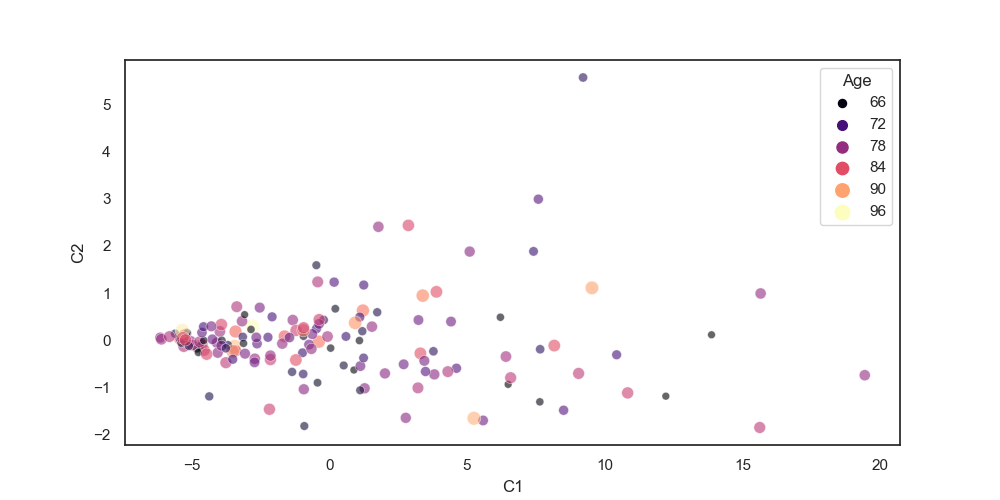

<AxesSubplot:xlabel='C1', ylabel='C2'>

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(data=X, x='C1', y='C2', size='Age', hue=X['Age'].astype(int), palette='magma', sizes=(20, 70), alpha=0.6)

<IPython.core.display.Javascript object>


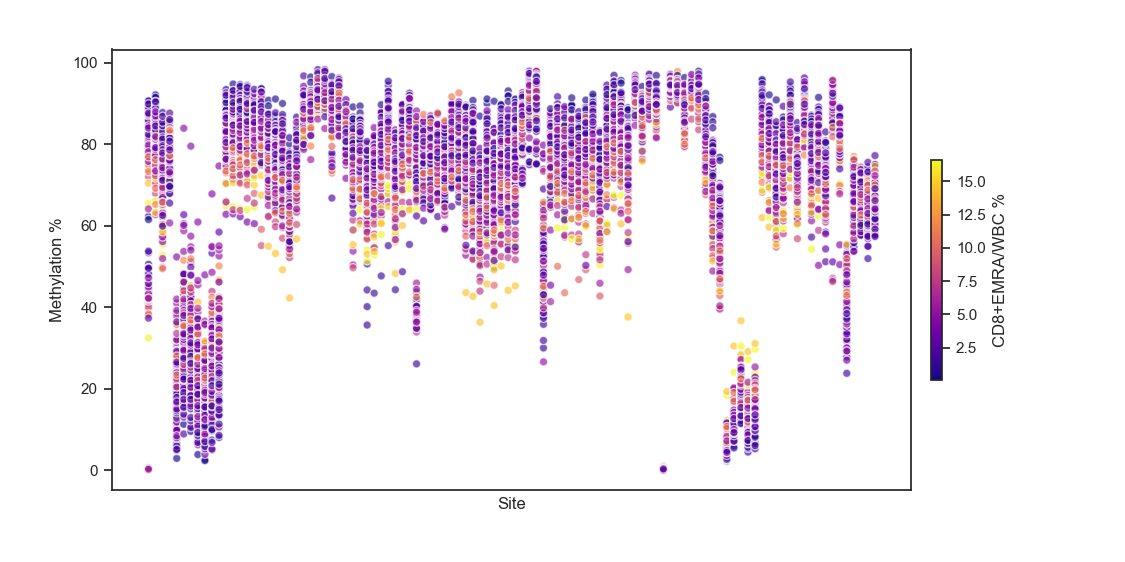

C:\Users\simopa\AppData\Local\Temp/ipykernel_29828/1000636223.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  bar = plt.colorbar(plot, shrink=0.5, aspect=20, drawedges=False, pad=0.02)


In [43]:
color = 'plasma'
col = 'CTLemra_WBC'
col_name = 'CD8+EMRA/WBC %'
data = datasets['IGA+IGN+EDU'].copy()
data = data.iloc[:, :-2] # remove age, sex

data, y = drop_na(data, y_all[col])
data *= 100
data = data.join(y)
data = data.rename(columns={col: col_name})

fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

plot = ax.scatter(data[col_name].index, data[col_name], c=data[col_name], cmap=color)
fig.clf()
#fig.suptitle('Distribution of methylation % across selected sites')
bar = plt.colorbar(plot, shrink=0.5, aspect=20, drawedges=False, pad=0.02)
bar.set_label(col_name)

data = pd.melt(data, id_vars=[col_name], var_name='Site', value_name='Methylation %')
ax = sns.scatterplot(data=data, x='Site', y='Methylation %', hue=col_name, legend=None, palette=color,
                marker='.', alpha=0.65, linewidths=None, s=90)
#ax.set_title('Distribution of methylation % across selected sites', fontdict={'fontsize':13})
plt.xticks([])
plt.tight_layout(pad=3)

ax.tick_params(left=True)

if not READ_ONLY:
    fig.savefig('../fig/{}_site_dist.png'.format(col), dpi=200)

<IPython.core.display.Javascript object>


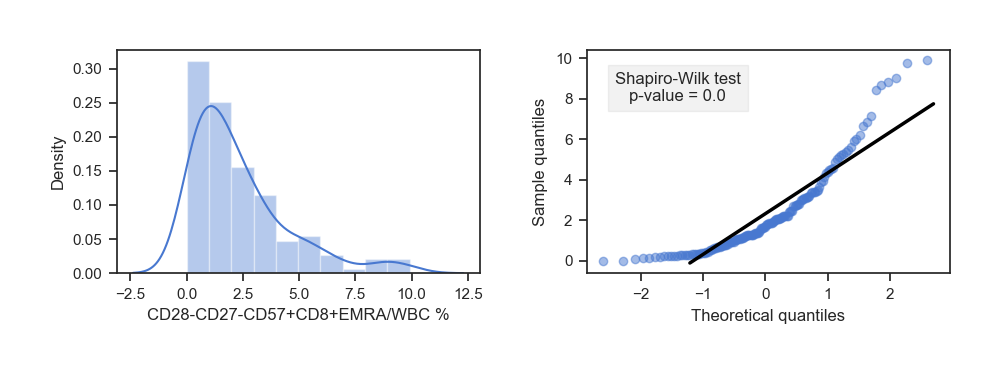

C:\Users\simopa\Anaconda3\envs\bio\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [161]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.set_palette("muted")
colors = sns.color_palette()
colors_dark = sns.hls_palette(8, l=0.5)

y = y_all['senCTLemra_WBC'].dropna()
sns.distplot(y, bins=10, ax=axes[0], color=colors[0])
axes[0].set_ylabel('Density')
axes[0].set_xlabel('CD28-CD27-CD57+CD8+EMRA/WBC %')
axes[0].tick_params(left=True, bottom=True)

(x, y), (k, b, r) = stats.probplot(y)
line_x = np.array([(-0.1-b)/k, np.max(x) + 0.1])
line_y = line_x * k + b
axes[1].scatter(x, y, marker='o', alpha=0.5, color=colors[0])
#sns.scatterplot(x=x, y=y, ax=axes[1], palette=colors, s=50)
axes[1].plot(line_x, line_y, linewidth=2, color='black')
axes[1].set_ylabel('Sample quantiles')
axes[1].set_xlabel('Theoretical quantiles')
axes[1].tick_params(left=True, bottom=True)
W, p = stats.shapiro(y)
plt.tight_layout(pad=3)
axes[1].text(0.25, 0.77, 'Shapiro-Wilk test\np-value = {}'.format(round(p, 2)), transform=axes[1].transAxes,
             bbox=dict(color='gray', alpha=0.1), horizontalalignment='center')

if not READ_ONLY:
    fig.savefig('../fig/qqplot_senCTLemra_WBC.png', dpi=200)

In [45]:
SIMPLE_POWS = [('id', lambda x: x, lambda x: x), ('sqrt', np.sqrt, np.square), ('cbrt', np.cbrt, lambda x: np.power(x, 3))]
LOG_POWS = [('log2', np.log2, lambda x: np.power(2.0, x)), ('log', np.log, np.exp),
            ('log10', np.log10, lambda x: np.power(10.0, x)), ('logit', lambda x: logit(x / 100), lambda x: expit(x) * 100)]
POWS = SIMPLE_POWS + LOG_POWS

def normalize(y, log_offset=None):
    y = y.dropna()
    y_off = y

    if offset is not None:
        y_off += offset
        
    best = None
    y_norms = {}
    pvals = {}

    for el in POWS:
        name, fn, inv_fn = el

        y_norm = fn(y if el in SIMPLE_POWS else y_off)
        W, p = stats.shapiro(y_norm)
        y_norms[name] = y_norm
        pvals[name] = p
        
        # Pick the simplest transformation
        if best is None and p >= 0.05:
            best = name
            
    if best is None:
        best = 'id'
        
    return y_norms, pvals, best

In [46]:
y_all_norm_series = []
y_norm_inv_fn = {}
y_norm_names = {}
OFFSETS = {'PD1pos_CTLemra_LYMP': 0.5, 'PD1pos_CTLemra_WBC': 0.1, 'THemra_WBC': 0.1, 'THemra_CD3': 0.2}

for label in reg_labels:
    offset = OFFSETS[label] if label in OFFSETS else None
    y_norms, pvals, best = normalize(y_all[label], offset)
    #print(label, [(name, pvals[name]) for name in reversed(sorted(pvals, key=lambda k: pvals[k]))])
    
    if label.endswith('_LYMP'):
        visualize_norm(y_norms, pvals, best, label)

    y_all_norm_series += [pd.Series(y_norms[best])]
    inv_fn_o = [inv_fn for name, fn, inv_fn in POWS if name == best][0]
    inv_fn = inv_fn_o

    if offset is not None and best != 'id':
        offs = offset
        inv_fn = lambda x, inv_fn_o=inv_fn_o: inv_fn_o(x) - offs

    y_norm_inv_fn[label] = inv_fn
    y_norm_names[label] = best

y_all_norm = pd.concat(y_all_norm_series, axis='columns', sort=True)

<IPython.core.display.Javascript object>


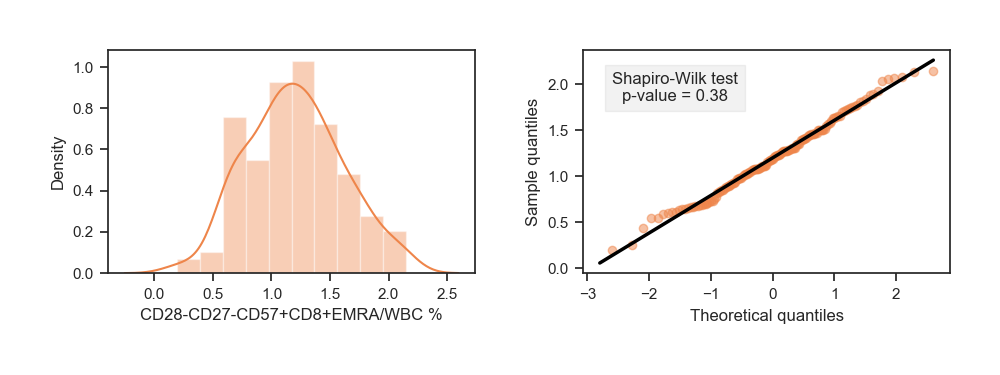

C:\Users\simopa\Anaconda3\envs\bio\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [162]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

y = y_all_norm['senCTLemra_WBC'].dropna()
sns.distplot(y, bins=10, ax=axes[0], color=colors[1])
axes[0].set_ylabel('Density')
axes[0].set_xlabel('CD28-CD27-CD57+CD8+EMRA/WBC %')
axes[0].tick_params(left=True, bottom=True)

(x, y), (k, b, r) = stats.probplot(y)
line_x = np.array([-2.8, np.max(x) +0])
line_y = line_x * k + b
axes[1].scatter(x, y, marker='o', alpha=0.5, color=colors[1])
#sns.scatterplot(x=x, y=y, ax=axes[1], palette=colors, s=50)
axes[1].plot(line_x, line_y, linewidth=2, color='black')
axes[1].set_ylabel('Sample quantiles')
axes[1].set_xlabel('Theoretical quantiles')
axes[1].tick_params(left=True, bottom=True)
W, p = stats.shapiro(y)
plt.tight_layout(pad=3)
axes[1].text(0.25, 0.77, 'Shapiro-Wilk test\np-value = {}'.format(round(p, 2)), transform=axes[1].transAxes,
             bbox=dict(color='gray', alpha=0.1), horizontalalignment='center')

if not READ_ONLY:
    fig.savefig('../fig/qqplot_senCTLemra_WBC_cbrt.png', dpi=200)

<IPython.core.display.Javascript object>


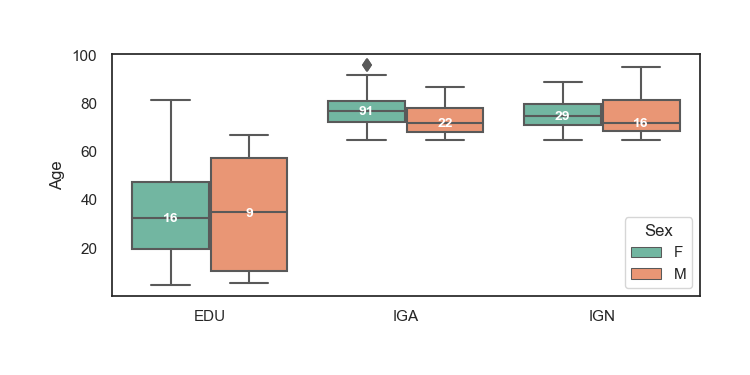

In [48]:
data = datasets['IGA+IGN+EDU'].copy()
data['Group'] = data.index.map(lambda x: x[:3])
data['Sex'] = data['female'].map(lambda x: 'F' if x else 'M')
data['Age'] = data['age']
data = data.dropna()

fig, axes = plt.subplots(1, 1, figsize=(6, 3))
sns.boxplot(ax=axes, data=data, y='Age', x='Group', hue='Sex', palette='Set2')
#sns.swarmplot(ax=axes, data=data, y='Age', x='Group', hue='Sex', palette='Set2')
medians = data.groupby(['Group', 'Sex'])['Age'].median().values
nobs = data.groupby(['Group', 'Sex'])['Age'].count()
nobs = [str(x) for x in nobs]

for tick in range(len(nobs)):
    x = tick // 2
    if tick % 2 == 0:
        x -= 0.2
    else:
        x += 0.2
    axes.text(x, medians[tick] - 1.8, nobs[tick],
        horizontalalignment='center', size=8, color='w', weight='semibold')

axes.set_xlabel('')
plt.tight_layout(pad=3)

if not READ_ONLY:
    fig.savefig('../fig/boxplot_age_sex.png', dpi=200)

In [49]:
# Transformed data
data_all = {}

for label in reg_labels:
    X, y = drop_na(datasets['IGA+IGN+EDU'][common_feats], y_all_norm[label])
    data_all[label] = (X, y)
    
#X, y = drop_na(datasets['V'][common_feats], y_all['disease'])
#data_all['disease'] = (X, y)

In [50]:
# Untransformed data - just to see if transformation made anything better
data_all_ut = {}

for label in reg_labels:
    X, y = drop_na(datasets['IGA+IGN+EDU'][common_feats], y_all[label])
    data_all_ut[label] = (X, y)
    
#X, y = drop_na(datasets['V'][common_feats], y_all['disease'])
#data_all_ut['disease'] = (X, y)

In [51]:
y_norm_names

{'LYMP_WBC': 'id',
 'CD3_WBC': 'id',
 'CD4_WBC': 'sqrt',
 'CD8_WBC': 'sqrt',
 'CTLemra_WBC': 'cbrt',
 'CD28neg_CTLemra_WBC': 'cbrt',
 'PD1pos_CTLemra_WBC': 'log2',
 'senCTLemra_WBC': 'cbrt',
 'CD127neg_CTLemra_WBC': 'cbrt',
 'CD28_27neg_CTLemra_WBC': 'cbrt'}

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class BorutaWrapper(BorutaPy):
    def _fit(self, X, y):
        res = super()._fit(X.values, y.values)
        all_feats = [col for col in X.columns]
        self.expected_feats = [col for col in X.columns[self.support_]]
        self.feats = self.expected_feats if len(self.expected_feats) > 0 else all_feats
        if len(self.expected_feats) == 0:
            print('Feature selection returned 0 features')
        return res

    def _transform(self, X, weak=False):
        return pd.DataFrame(X, columns=self.feats)

In [53]:
def get_feature_selector(is_regression=True):
    if is_regression:
        model = RandomForestRegressor(max_depth=5, n_jobs=1, random_state=RANDOM_STATE_SEED+53)
    else:
        model = RandomForestClassifier(max_depth=5, n_jobs=1, random_state=RANDOM_STATE_SEED+11, class_weight='balanced')

    return BorutaWrapper(model, max_iter=50, verbose=0, n_estimators='auto')

def select_features(X, y, is_regression=True):
    feat_model = get_feature_selector(is_regression)
    feat_model.fit(X.values, y.values)
    return [col for col in X.columns[feat_model.support_]]

In [258]:
np.linspace(10, 30, 3, dtype=int)

array([10, 20, 30])

In [321]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, LogisticRegression, HuberRegressor, Lasso
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from joblib import Memory

ALPHA = np.logspace(-4, 1, 6)

Method = namedtuple('Method', ['name', 'model', 'params'])
reg_methods = [Method(*x) for x in [
    ('Linear', LinearRegression(n_jobs=-1), {}),
    #('Huber', HuberRegressor(), dict(alpha=np.logspace(-2, 2, 5), epsilon=np.linspace(1.2, 1.5, 4))),
    ('Ridge', Ridge(), dict(alpha=ALPHA)),
    ('Lasso', Lasso(selection='random'), dict(alpha=ALPHA)),
    #('ElasticNet', ElasticNet(selection='random'), dict(alpha=ALPHA, l1_ratio=np.linspace(0.2, 0.8, 4))),
    #('SV', SVR(), [dict(kernel=['linear', 'rbf', 'sigmoid'], C=np.logspace(0, 3, 4), epsilon=[0] + ALPHA.tolist())]),
    ('RandomForest', RandomForestRegressor(n_jobs=1, random_state=RANDOM_STATE_SEED+52, min_samples_leaf=2),
     dict(n_estimators=np.linspace(100, 1000, 5, dtype=int), max_depth=np.linspace(10, 30, 3, dtype=int).tolist()))
]]

ModelInstanceKey = namedtuple('ModelInstanceKey', ['method_name', 'select_features'])
model_instances = {}

for method, select_features in product(reg_methods, [False, True]):
    key = ModelInstanceKey(method.name, select_features)
    #steps = [StandardScaler(), method.model]
    steps = [method.model]
    
    if select_features:
        steps = [get_feature_selector()] + steps
        
    model_instances[key] = make_pipeline(*steps, verbose=True, memory=memory)

def rename_param_dict(step_name, params):
    return {'{}__{}'.format(step_name.lower(), key): params[key] for key in params}

def method_by_name(name):
    return [method for method in reg_methods if method.name == name][0]

def tune_hyper(X, y, method, cv=3, grid=True, select_features=True):
    key = ModelInstanceKey(method.name, select_features)
    model = model_instances[key]
    last_step = model.steps[-1][0]
    
    if type(method.params) == dict:
        params = rename_param_dict(last_step, method.params)
    else:
        params = [rename_param_dict(last_step, param_dict) for param_dict in method.params]

    if grid:
        hyper_model = GridSearchCV(model, params, n_jobs=1, cv=cv, refit=True, error_score=0,
                                   return_train_score=True, scoring='neg_mean_squared_error', verbose=4)
    else:
        hyper_model = RandomizedSearchCV(model, params, n_jobs=1, cv=cv, refit=True, error_score=0,
                                         return_train_score=True, random_state=RANDOM_STATE_SEED+77, verbose=4)
        
    print('Tuning hyerparameters (inner CV folds) for {} (grid={}, select_features={})'\
          .format(method.name, grid, select_features))
    hyper_model.fit(X, y)
    print('Selected params: {}'.format(hyper_model.best_params_))

    return hyper_model

In [59]:
def extract_failed_from_cv_results(cv_results):
    params = np.array(cv_results['params'])
    zeroes_per_param = defaultdict(int)

    for key in [key for key in cv_results if re.compile('split[0-9]+_train_score').match(key)]:
        scores = np.array(cv_results[key])
        zeroes = np.nonzero(scores == 0)

        if len(zeroes) == 0:
            continue

        for param in params[zeroes]:
            zeroes_per_param[str(param)] += 1
            
    if len(zeroes_per_param):
        print('WARNING - found train scores with 0!')
        print(dict(zeroes_per_param))
        print()

In [60]:
Key = namedtuple('Key', ['label', 'method_name'])
predicted = defaultdict(list)
models = defaultdict(list)

In [ ]:
# This is where we actually train and evaluate models, using the *transformed* labels

for label in reg_labels:
    print('Label {}'.format(label))
    X, y = data_all[label]
    scores = []
    
    #fig, axes = plt.subplots(1, len(reg_methods), figsize=(5*len(reg_methods), 5))
    #axes[0].get_shared_y_axes().join(*axes)
    #fig.suptitle(label)

    for i, method in enumerate(reg_methods):
        key = Key(label, method.name)
        
        if READ_ONLY:
            predicted[key] = pd.read_pickle('./predicted_{}.pkl'.format(key))
            models[key] = load('./models_{}'.format(key))
            continue
        
        predicted[key] = []
        models[key] = []
        failed = False

        print('Evaluating method {}'.format(method.name))

        for i, (train, test) in enumerate(KFold(5, shuffle=True, random_state=RANDOM_STATE_SEED+98).split(X)):
            print('Outer fold nr {}'.format(i+1))
            X_train, X_test, y_train, y_test = X.iloc[train, :], X.iloc[test, :], y.iloc[train], y.iloc[test]

            try:
                tuned_model = tune_hyper(X_train, y_train, method, select_features=True)
            except Exception as e:
                failed = True
                print('Refitting failed:', e)
                break

            extract_failed_from_cv_results(tuned_model.cv_results_)
            models[key].append(tuned_model)
            y_test_pred = tuned_model.predict(X_test)

            y_true, y_pred = [y_norm_inv_fn[label](curr_y) for curr_y in [y_test, y_test_pred]]
            predicted[key].append(pd.DataFrame({'true': y_true, 'pred': y_pred, 'fold': i, 'codes': X_test.index.values}))
            scores.append(mean_squared_error(y_true, y_pred))

        if failed:
            del predicted[key]
            continue

        predicted[key] = pd.concat(predicted[key])
        
        predicted[key].to_pickle('./predicted_{}.pkl'.format(key))
        dump(models[key], './models_{}'.format(key))
        
        #visualize_reg(predicted[key]['true'], predicted[key]['pred'], method.name, axes[i], np.mean(np.sqrt(scores)))
        print()

In [62]:
predicted_ut = defaultdict(list)
models_ut = defaultdict(list)

In [ ]:
# This is where we actually train and evaluate models, using the *untransformed* labels

for label in reg_labels:
    print('Label {}'.format(label))
    X, y = data_all_ut[label]
    scores = []
    
    #fig, axes = plt.subplots(1, len(reg_methods), figsize=(5*len(reg_methods), 5))
    #axes[0].get_shared_y_axes().join(*axes)
    #fig.suptitle(label)

    for i, method in enumerate(reg_methods):
        key = Key(label, method.name)
        
        if READ_ONLY:
            predicted_ut[key] = pd.read_pickle('./predicted_ut_{}.pkl'.format(key))
            models_ut[key] = load('./models_ut_{}'.format(key))
            continue
            
        predicted_ut[key] = []
        models_ut[key] = []
        failed = False

        print('Evaluating method {}'.format(method.name))

        for i, (train, test) in enumerate(KFold(5, shuffle=True, random_state=RANDOM_STATE_SEED+98).split(X)):
            X_train, X_test, y_train, y_test = X.iloc[train, :], X.iloc[test, :], y.iloc[train], y.iloc[test]
            
            try:
                tuned_model = tune_hyper(X_train, y_train, method)
            except:
                failed = True
                print('Refitting failed', sys.exc_info()[0])
                break

            extract_failed_from_cv_results(tuned_model.cv_results_)
            models_ut[key].append(tuned_model)
            y_test_pred = tuned_model.predict(X_test)

            y_true, y_pred = [y_test, y_test_pred]
            predicted_ut[key].append(pd.DataFrame({'true': y_true, 'pred': y_pred, 'fold': i, 'codes': X_test.index.values}))
            scores.append(mean_squared_error(y_true, y_pred))

        if failed:
            del predicted_ut[key]
            continue

        predicted_ut[key] = pd.concat(predicted_ut[key])
        
        predicted_ut[key].to_pickle('./predicted_ut_{}.pkl'.format(key))
        dump(models_ut[key], './models_ut_{}'.format(key))
        
        #visualize_reg(predicted[key]['true'], predicted[key]['pred'], method.name, axes[i], np.mean(np.sqrt(scores)))
        print()

In [297]:
best_models = {}
best_models_ut = {}
palette = {'IGA': colors[0], 'IGN': colors[1], 'EDU': colors[2]}

<IPython.core.display.Javascript object>


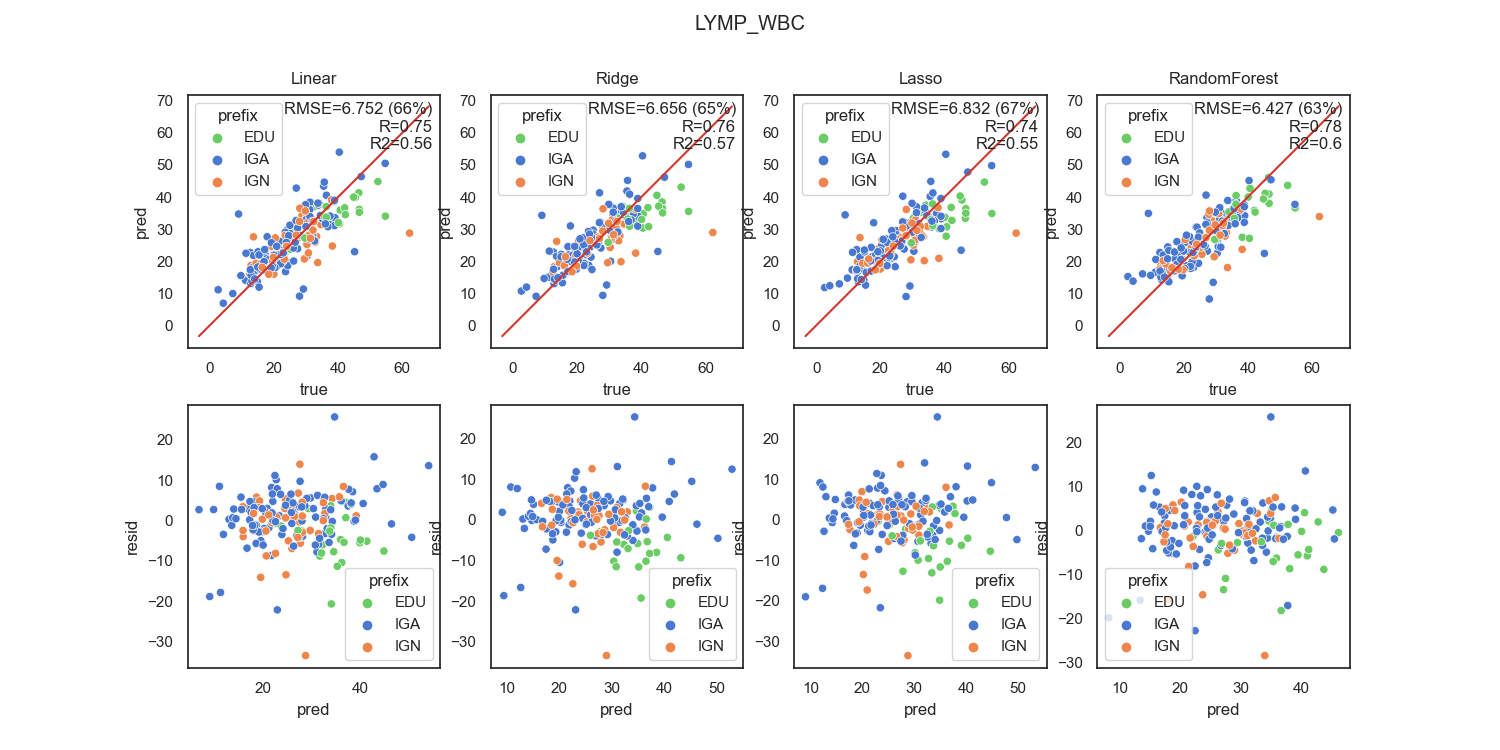

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


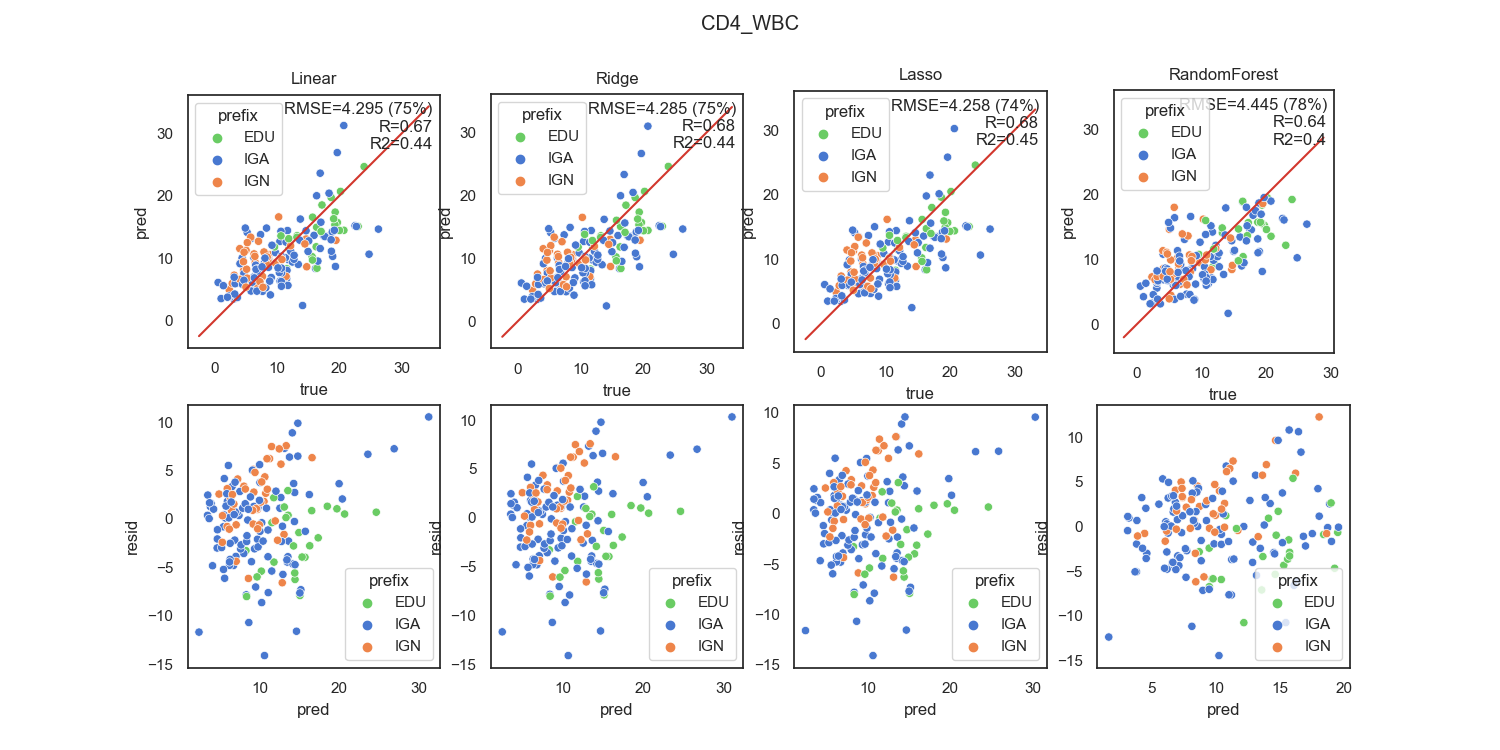

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


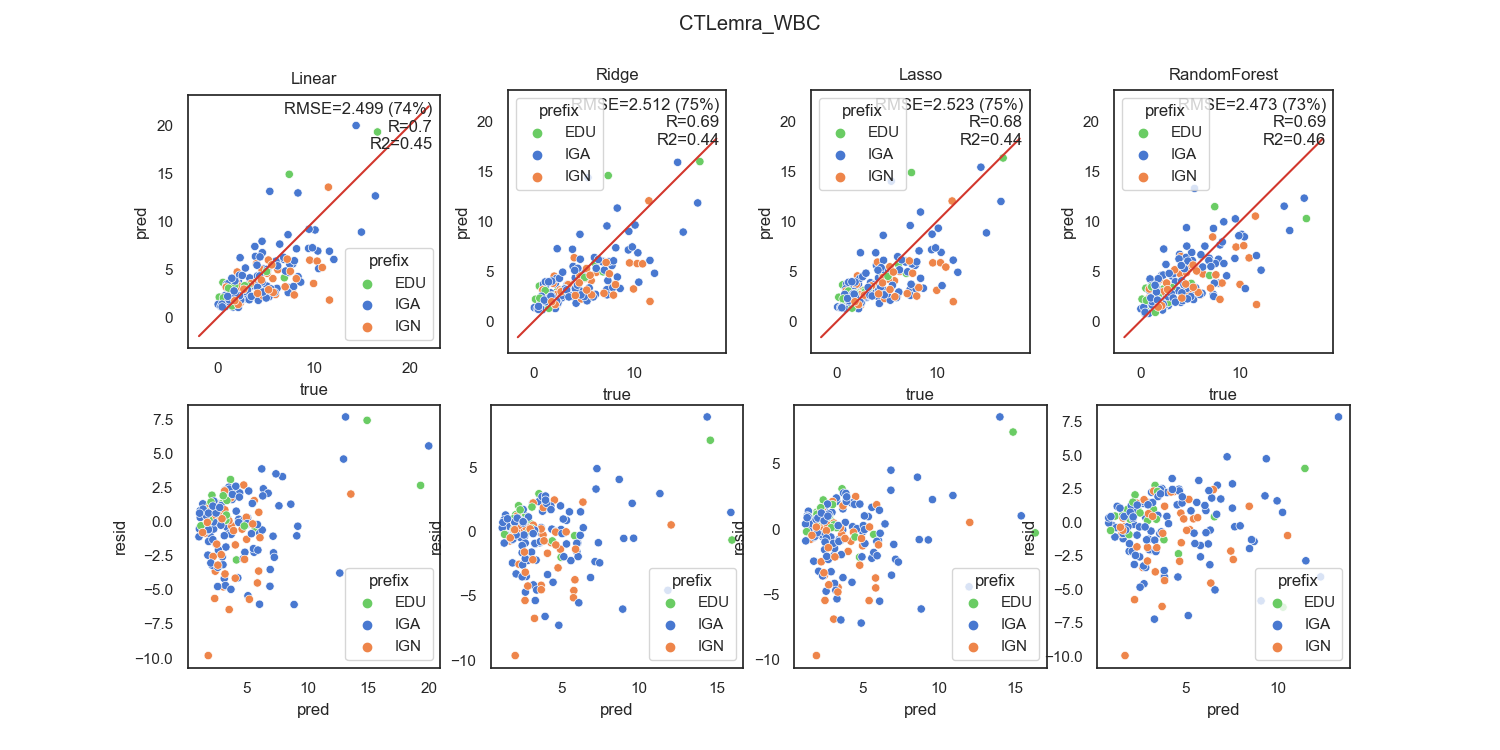

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


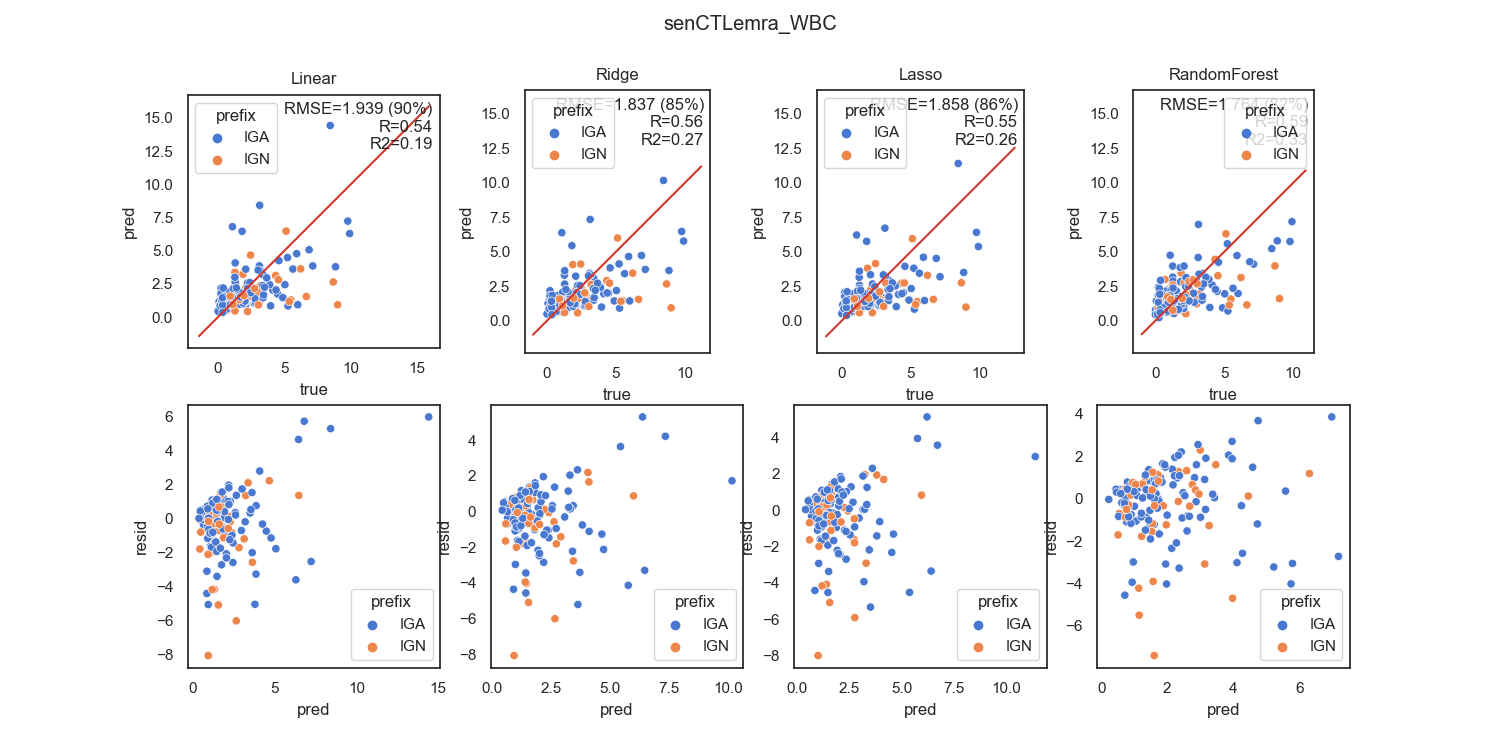

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'LYMP_WBC': 'RandomForest',
 'CD3_WBC': 'Ridge',
 'CD4_WBC': 'Lasso',
 'CD8_WBC': 'Lasso',
 'CTLemra_WBC': 'RandomForest',
 'CD28neg_CTLemra_WBC': 'Ridge',
 'PD1pos_CTLemra_WBC': 'Lasso',
 'senCTLemra_WBC': 'RandomForest',
 'CD127neg_CTLemra_WBC': 'Lasso',
 'CD28_27neg_CTLemra_WBC': 'Lasso'}

In [545]:
# Visualize predictions with *transformed* labels

for label in reg_labels:
    fig, axes = plt.subplots(2, 4, figsize=(3*4, 3*2))
    axes[0,0].get_shared_y_axes().join(*axes[0])
    fig.suptitle(label)
    scores = {}
    
    for i, key in enumerate([x for x in predicted if x.label == label]):
        vals = predicted[key]
        if type(vals) == list:
            continue
        print()
        score = mean_squared_error(vals['true'], vals['pred'])
        scores[key.method_name] = score
        vals['resid'] = vals['pred'] - vals['true']
        vals['fold_str'] = vals['fold'].map(lambda x: 'r' + str(x))
        vals['prefix'] = vals['codes'].map(lambda x: x[:3])

        visualize_reg(vals, key.method_name, axes[0,i], score, 'prefix', palette)
        sns.scatterplot(x=vals['pred'], y=vals['resid'], hue=vals['prefix'], ax=axes[1,i], palette=palette)
    filt = [(m, scores[m]) for m in sorted(scores, key=lambda k: scores[k]) if m in ['Linear', 'Ridge', 'Lasso', 'RandomForest']]
    if len(filt) > 0:
        best_models[label] = filt[0][0]
        
best_models

In [ ]:
# Visualize predictions with *untransformed* labels

for label in reg_labels:
    fig, axes = plt.subplots(2, 4, figsize=(3*4, 3*2))
    axes[0,0].get_shared_y_axes().join(*axes[0])
    fig.suptitle(label)
    scores = {}
    for i, key in enumerate([x for x in predicted_ut if x.label == label]):
        vals = predicted_ut[key]
        if type(vals) == list:
            continue
        print()
        score = mean_squared_error(vals['true'], vals['pred'])
        scores[key.method_name] = score
        vals['resid'] = vals['pred'] - vals['true']
        vals['fold_str'] = vals['fold'].map(lambda x: 'r' + str(x))
        vals['prefix'] = vals['codes'].map(lambda x: x[:3])

        visualize_reg(vals, key.method_name, axes[0,i], score, 'prefix', palette)
        sns.scatterplot(x=vals['pred'], y=vals['resid'], hue=vals['prefix'], ax=axes[1,i], palette=palette)
    filt = [(m, scores[m]) for m in sorted(scores, key=lambda k: scores[k]) if m in ['Linear', 'Ridge', 'Lasso', 'RandomForest']]
    if len(filt) > 0:
        best_models_ut[label] = filt[0][0]
        
best_models_ut

In [255]:
names = {
    'LYMP_WBC': 'LYMP/WBC',
    'CD3_WBC': 'CD3+/WBC',
    'CD4_WBC': 'CD4+/WBC',
    'CD8_WBC': 'CD8+/WBC',
    'CTLemra_WBC': 'CD8+EMRA/WBC',
    'CD28neg_CTLemra_WBC': 'CD28-CD8+EMRA/WBC',
    'CD28neg_CTLemra_LYMP': 'CD28-CD8+EMRA/LYMP',
    'CD28_27neg_CTLemra_LYMP': 'CD28-CD27-CD8+EMRA/LYMP',
    'CD28_27neg_CTLemra_WBC': 'CD28-CD27-CD8+EMRA/WBC',
    'PD1pos_CTLemra_WBC': 'PD1+CD8+EMRA/WBC',
    'senCTLemra_WBC': 'CD28-CD27-CD57+CD8+EMRA/WBC',
    'CD127neg_CTLemra_WBC': 'CD127-CD8+EMRA/WBC'
}

In [ ]:
for label in best_models:
    key = Key(label, best_models[label])
    fig, axes = plt.subplots(1, 1, figsize=(4,4))

    vals = predicted[key]
    if type(vals) == list:
        print('WTF')
    score = mean_squared_error(vals['true'], vals['pred'])
    vals['resid'] = vals['pred'] - vals['true']
    vals['fold_str'] = vals['fold'].map(lambda x: 'r' + str(x))
    vals['prefix'] = vals['codes'].map(lambda x: x[:3])
    vals['Error'] = vals['resid']
    vals['Actual'] = vals['true']
    vals['Predicted'] = vals['pred']
    vals['Group'] = vals['prefix']

    #visualize_reg(vals, key.method_name, axes, score, 'prefix')
    sns.scatterplot(x=vals['Predicted'], y=vals['Actual'], hue=vals['Group'], ax=axes, legend=True, palette=palette)
    plt.legend( loc='lower right',facecolor='#EEEEEE', framealpha=0.5, edgecolor='1', handlelength=1)
    name = label.replace('_', '/') if label not in names else names[label]
    axes.set_title(name + ' %\n' + key.method_name + ' regression')
    y_max, y_min = np.max(vals['pred']), np.min(vals['pred'])
    tail = (y_max - y_min) / 50
    line = np.array([y_min - tail, y_max + tail])
    axes.plot(line, line, dashes=[6, 2], color='black', linewidth=1.5)
    mse = np.mean(np.square(vals['resid']))
    mae = np.mean(np.abs(vals['resid']))
    r, p = stats.pearsonr(vals['true'], vals['pred'])
    axes.text(0.185, 0.805, 'RMSE\nMAE\nR', transform=axes.transAxes,
                 bbox=dict(color='#EEEEEE', alpha=0.5, boxstyle='round,rounding_size=0.2'), horizontalalignment='right')
    axes.text(0.25, 0.805, '{}\n{}\n{}'.format(round(np.sqrt(mse), 2), round(mae, 2), round(r, 2)),
              transform=axes.transAxes,
                 bbox=dict(color='#EEEEEE', alpha=0.5, boxstyle='round,rounding_size=0.2'), horizontalalignment='left')
    plt.tight_layout(pad=3)
    #plt.xlim(max(-1, y_min - 1), None)
    
    if not READ_ONLY:
        fig.savefig('../fig/{}_res.png'.format(label), dpi=200)

In [ ]:
final_models = {}

for label in best_models:
    print('Label {}'.format(label))
    X, y = data_all[label]
    method = method_by_name(best_models[label])

    try:
        tuned_model = tune_hyper(X, y, method, select_features=True)
    except:
        print('Refitting failed', sys.exc_info()[0])
        continue
    
    extract_failed_from_cv_results(tuned_model.cv_results_)
    final_models[label] = tuned_model

In [ ]:
linear_models = {}
linear_models_ut = {}

for label in reg_labels:
    print('Label {}'.format(label))
    method = [method for method in reg_methods if method.name == 'Linear'][0]
    
    for (models, data) in [(linear_models, data_all), (linear_models_ut, data_all_ut)]:
        X, y = data[label]

        try:
            tuned_model = tune_hyper(X, y, method, select_features=True)
        except:
            print('Refitting failed', sys.exc_info()[0])
            continue

        extract_failed_from_cv_results(tuned_model.cv_results_)
        models[label] = tuned_model

In [328]:
with open('bismark_site_map.pkl', 'rb') as f:
    site_map = pickle.load(f)
    reverse_site_map = {'S{}'.format(v): k for k, v in site_map.items()} # new_site -> old_site

In [423]:
import requests

pos_to_proteins = {}
def get_proteins(pos):
    if pos in pos_to_proteins:
        return pos_to_proteins[pos]
    
    proteins = []
    [chrom, loc] = pos.split(':')
    
    for offset in [1, 100]:
        url = "https://api.genome.ucsc.edu/getData/track?genome=hg19;chrom=chr{};start={};end={};track=knownGene".format(chrom, int(loc)-offset, int(loc)+offset)
        print(url)
        response = requests.get(url)
        new_proteins = list(set([gene['proteinID'] for gene in response.json()['knownGene'] if len(gene['proteinID']) > 0]))
        proteins += new_proteins
        
        if len(new_proteins) > 0:
            break

    pos_to_proteins[pos] = proteins
    return proteins

#protein_descs = {}
def get_protein_descs(protid):
    if protid in protein_descs:
        return protein_descs[protid]

    descs = []
    url = "https://www.uniprot.org/uniprot/{}.tab".format(protid)
    print(url)
    response = requests.get(url)
    
    if response.status_code == 200:
        descs = [response.text.split('\n')[1].split('\t')[3]]
        #names = [name for field in ['recommendedName', 'submittedName'] if field in response for name in (response[field] if type(response[field]) is list else [response[field]])]
        #descs = list(set([name['fullName']['value'] for name in names]))
    
    protein_descs[protid] = descs
    return descs

In [ ]:
sites = list(set([pos for label in final_models for pos in data_all[label][0].columns[final_models[label].best_estimator_.steps[0][1].support_]]))
positions = [reverse_site_map[pos] for pos in mapped_sites]
descs = {pos: '.....................'.join(set([desc for protid in get_proteins(pos) for desc in get_protein_descs(protid)])) for pos in positions}

selected_feats = pd.DataFrame(pd.Series(descs, index=positions, name='Genes'))
selected_feats.index = sites
for label in final_models:
    cols = X.columns[final_models[label].best_estimator_.steps[0][1].support_]
    sites_mask = [site in cols for site in sites]
    selected_feats = selected_feats.join(pd.Series(sites_mask, index=sites, name=label))
    
pd.set_option('display.max_colwidth', None)
selected_feats.index = selected_feats.index.map(lambda s: reverse_site_map[s])
selected_feats.sort_index().to_csv('annotations.csv')

<IPython.core.display.Javascript object>


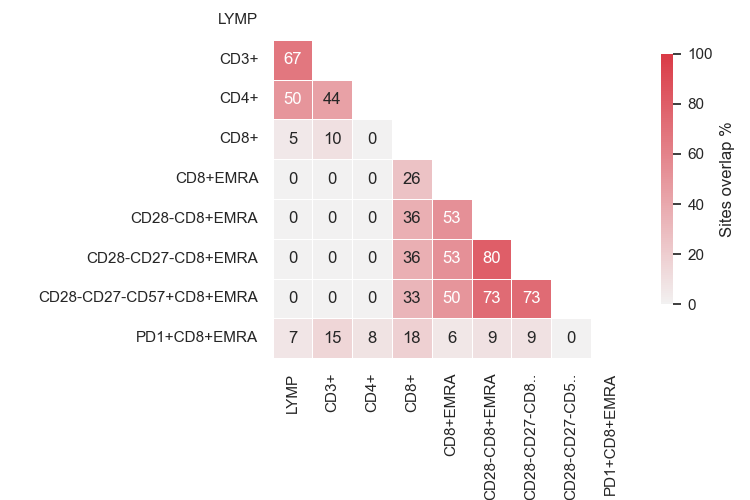

In [544]:
feat_heatmap = selected_feats.drop('Genes', axis='columns')
feat_heatmap.columns = feat_heatmap.columns.map(lambda name: '{}'.format(names[name].replace('/WBC', '')))
cols = ['LYMP', 'CD3+', 'CD4+', 'CD8+', 'CD8+EMRA', 'CD28-CD8+EMRA', 'CD28-CD27-CD8+EMRA', 'CD28-CD27-CD57+CD8+EMRA', 'PD1+CD8+EMRA']
cols_short = [col[:13] + '..' if len(col) >= 15 else col for col in cols]
feat_heatmap = feat_heatmap[cols]
corr = round(feat_heatmap.corr(method=lambda x, y: ((x == 1) & (y == 1)).sum() / ((x == 1) | (y == 1)).sum()) * 100)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=100, annot=True, xticklabels=cols_short,
            square=True, linewidths=.5, cbar_kws={"shrink": .7, 'label': 'Sites overlap %'})
#for t in ax.texts: t.set_text(t.get_text() + " %")
f.tight_layout(pad=0)
if not READ_ONLY:
    f.savefig('../fig/common_sites.png', dpi=200)

In [ ]:
for site in selected_feats.index:
    print(site)
    print('\n'.join(['\t >> ' + desc for desc in selected_feats['Genes'][site].split('; ')]))
    print()

In [161]:
#memory.clear(warn=False)

<IPython.core.display.Javascript object>


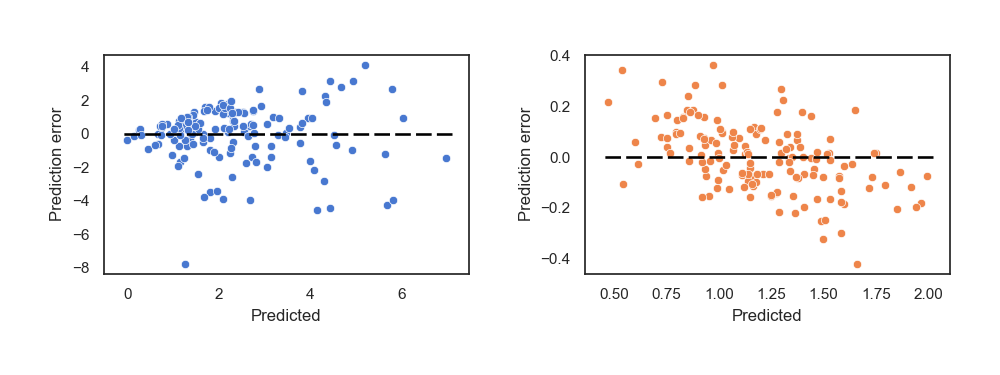

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
#fig.suptitle('Residuals plot')

for (i, (d, m)) in enumerate([(data_all_ut, final_models_ut), (data_all, final_models)]):
    X, y = d['senCTLemra_WBC']
    pred = m['senCTLemra_WBC'].predict(X)
    resid = pred - y
    sns.scatterplot(x=pred, y=resid, ax=axes[i], color=colors[i])
    y_max, y_min = np.max(pred), np.min(pred)
    tail = (y_max - y_min) / 50
    axes[i].plot(np.array([y_max + tail, y_min - tail]), np.array([0, 0]), dashes=[6, 2], color='black', linewidth=1.5)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Prediction error')
    
plt.tight_layout(pad=3)
if not READ_ONLY:
    fig.savefig('../fig/residuals.png', dpi=200)

In [ ]:
df = pd.DataFrame()

for label in final_models:
    name = names[label] if label in names else label
    sites = [reverse_site_map[site] for site in data_all[label][0].columns[final_models[label].best_estimator_.steps[0][1].support_]]
    model = final_models[label].best_estimator_.steps[1][1]
    method = [method for method in reg_methods if type(method.model) == type(model)][0]
    selected_params = '\n'.join(['{}={}'.format(param, model.get_params()[param]) for param in method.params])
    df = df.append(pd.Series({'Method': method.name,
                              'Sites': len(sites),
                              'Hyperparameters': selected_params
                             }, name=name))
    df = df.astype({'Method': 'str', 'Sites': 'int32'})
    
print(df.to_latex())